In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv('forestfires.csv')

# Display initial information
print("Initial Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

# Display first few rows
print("\nFirst few rows:")
print(df.head())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None

Missing Values:
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Basic Statistics:
                X           Y        FFMC         DMC     

In [4]:
# Create a copy for cleaning
df_cleaned = df.copy()

# Convert categorical variables to numerical
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
day_map = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
}

df_cleaned['month'] = df_cleaned['month'].map(month_map)
df_cleaned['day'] = df_cleaned['day'].map(day_map)

# Handle outliers using IQR method
numerical_columns = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
for column in numerical_columns:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[
        (df_cleaned[column] >= lower_bound) &
        (df_cleaned[column] <= upper_bound)
    ]

In [5]:
# Create new features
df_cleaned['season'] = pd.cut(
    df_cleaned['month'],
    bins=[0, 3, 6, 9, 12],
    labels=['winter', 'spring', 'summer', 'fall']
)

# Calculate fire risk index
df_cleaned['fire_risk_index'] = (
    df_cleaned['temp'] * 0.3 +
    (100 - df_cleaned['RH']) * 0.3 +
    df_cleaned['wind'] * 0.2 +
    df_cleaned['FFMC'] * 0.2
)

# Create binary indicators
df_cleaned['high_temp'] = (df_cleaned['temp'] > df_cleaned['temp'].mean()).astype(int)
df_cleaned['low_humidity'] = (df_cleaned['RH'] < df_cleaned['RH'].mean()).astype(int)
df_cleaned['high_wind'] = (df_cleaned['wind'] > df_cleaned['wind'].mean()).astype(int)

In [6]:
# Select features for clustering
features_for_clustering = [
    'temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI', 'fire_risk_index'
]
X = df_cleaned[features_for_clustering]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

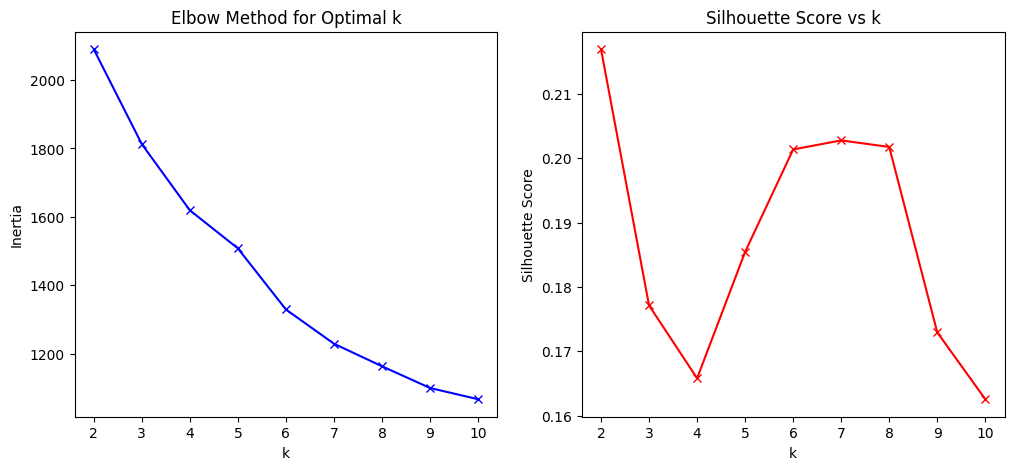

In [7]:
# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

# Perform K-means clustering with optimal k
optimal_k = 4  # Based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_cleaned['kmeans_cluster'] = kmeans_labels

In [9]:
# Block 7: Hierarchical Clustering (TensorFlow)
# Convert data to TensorFlow tensor
X_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
n_samples = X_tf.shape[0]
n_clusters = 4

# Initialize cluster assignments
clusters = tf.range(n_samples)
current_n_clusters = n_samples

# Calculate initial pairwise distances
expanded_a = tf.expand_dims(X_tf, 1)
expanded_b = tf.expand_dims(X_tf, 0)
distances = tf.reduce_sum(tf.square(expanded_a - expanded_b), 2)

# Perform hierarchical clustering
while current_n_clusters > n_clusters:
    # Find closest clusters
    mask = tf.linalg.band_part(tf.ones_like(distances), 0, -1)
    masked_distances = distances * mask
    large_num = tf.reduce_max(masked_distances) + 1
    masked_distances = tf.where(masked_distances == 0, large_num, masked_distances)

    # Fix: Convert shape to int64
    flat_index = tf.argmin(tf.reshape(masked_distances, [-1]))
    shape = tf.cast(tf.shape(distances), tf.int64)
    i, j = tf.unravel_index(flat_index, shape)

    # Convert indices to int32 for boolean masking
    i = tf.cast(i, tf.int32)
    j = tf.cast(j, tf.int32)

    # Merge clusters
    cluster_i = tf.boolean_mask(X_tf, clusters == i)
    cluster_j = tf.boolean_mask(X_tf, clusters == j)
    merged = tf.concat([cluster_i, cluster_j], 0)
    centroid = tf.reduce_mean(merged, 0)

    # Update assignments and data
    clusters = tf.where(clusters == j, i, clusters)
    mask = tf.range(X_tf.shape[0]) != j
    X_tf = tf.boolean_mask(X_tf, mask)
    X_tf = tf.concat([X_tf, tf.expand_dims(centroid, 0)], 0)

    # Update distances
    expanded_a = tf.expand_dims(X_tf, 1)
    expanded_b = tf.expand_dims(X_tf, 0)
    distances = tf.reduce_sum(tf.square(expanded_a - expanded_b), 2)

    current_n_clusters -= 1
    print(f"Current number of clusters: {current_n_clusters}")

# Add hierarchical clustering labels to dataframe
df_cleaned['hierarchical_cluster'] = clusters.numpy()

Current number of clusters: 347
Current number of clusters: 346
Current number of clusters: 345
Current number of clusters: 344
Current number of clusters: 343
Current number of clusters: 342
Current number of clusters: 341
Current number of clusters: 340
Current number of clusters: 339
Current number of clusters: 338
Current number of clusters: 337
Current number of clusters: 336
Current number of clusters: 335
Current number of clusters: 334
Current number of clusters: 333
Current number of clusters: 332
Current number of clusters: 331
Current number of clusters: 330
Current number of clusters: 329
Current number of clusters: 328
Current number of clusters: 327
Current number of clusters: 326
Current number of clusters: 325
Current number of clusters: 324
Current number of clusters: 323
Current number of clusters: 322
Current number of clusters: 321
Current number of clusters: 320
Current number of clusters: 319
Current number of clusters: 318
Current number of clusters: 317
Current 

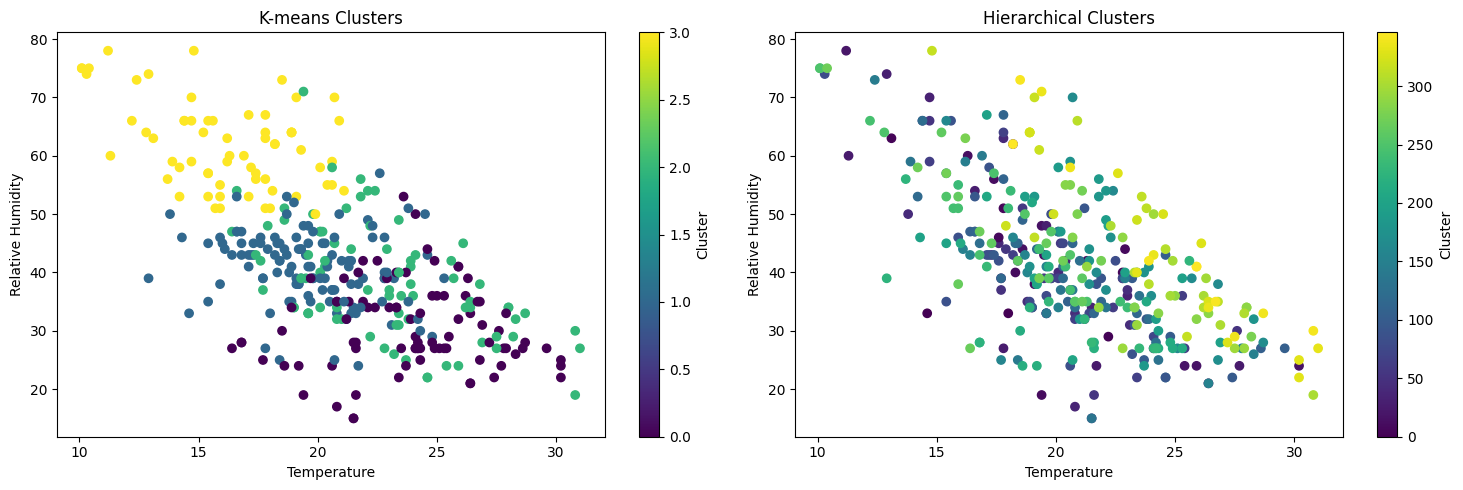

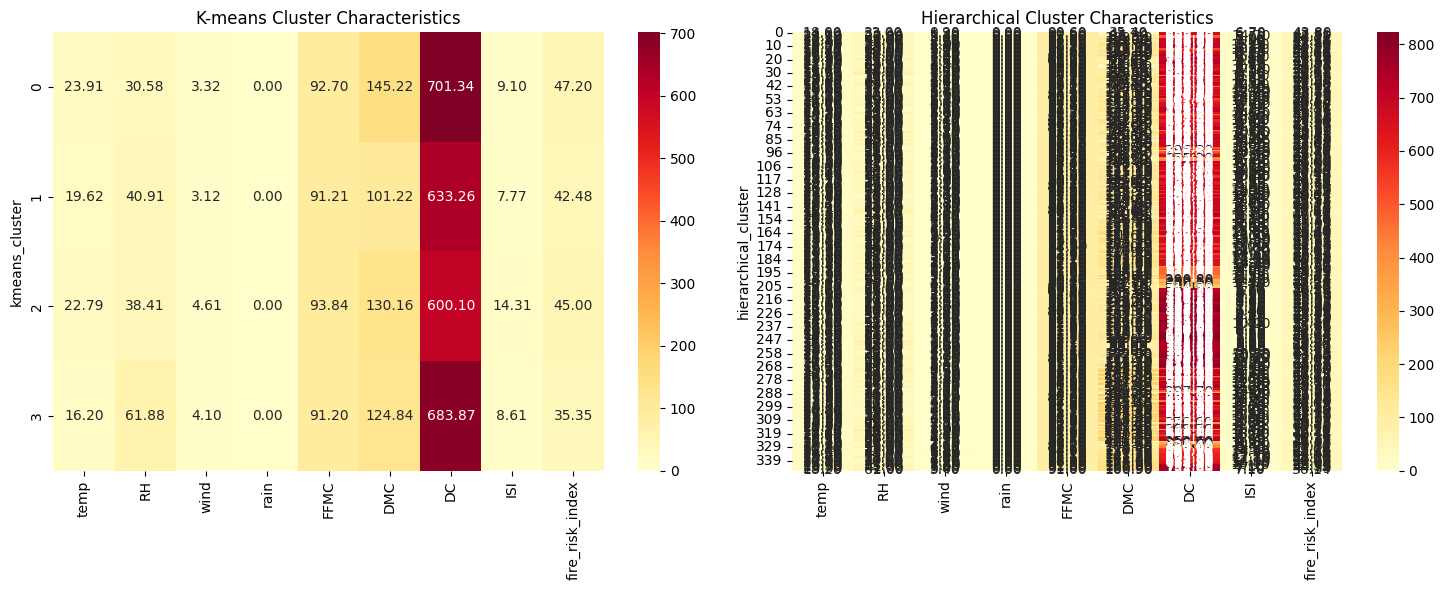


K-means Clustering Metrics:
Silhouette Score: 0.166
Davies-Bouldin Score: 1.718

Hierarchical Clustering Metrics:
Silhouette Score: -0.073
Davies-Bouldin Score: 1.443


In [10]:
# Create visualization for K-means clusters
plt.figure(figsize=(15, 5))

# Temperature vs Humidity colored by K-means clusters
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned['temp'], df_cleaned['RH'],
            c=df_cleaned['kmeans_cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Relative Humidity')
plt.title('K-means Clusters')
plt.colorbar(label='Cluster')

# Temperature vs Humidity colored by Hierarchical clusters
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned['temp'], df_cleaned['RH'],
            c=df_cleaned['hierarchical_cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Relative Humidity')
plt.title('Hierarchical Clusters')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Create heatmaps for cluster characteristics
plt.figure(figsize=(15, 6))

# K-means cluster characteristics
plt.subplot(1, 2, 1)
kmeans_stats = df_cleaned.groupby('kmeans_cluster')[features_for_clustering].mean()
sns.heatmap(kmeans_stats, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('K-means Cluster Characteristics')

# Hierarchical cluster characteristics
plt.subplot(1, 2, 2)
hierarchical_stats = df_cleaned.groupby('hierarchical_cluster')[features_for_clustering].mean()
sns.heatmap(hierarchical_stats, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Hierarchical Cluster Characteristics')

plt.tight_layout()
plt.show()

# Print cluster evaluation metrics
print("\nK-means Clustering Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, kmeans_labels):.3f}")

print("\nHierarchical Clustering Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters.numpy()):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, clusters.numpy()):.3f}")

# Save results
df_cleaned.to_csv('forestfires_clustered_results.csv', index=False)